In [1]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ML
from sklearn.metrics import classification_report, confusion_matrix
from errors import MAE

# Utilities
import h5py
import json
import project_utils as utils

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
colorList = cosmostyle.color_cycle

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]


# TODO: turn plotting and classification stats into functions

# Analysis setup

In [2]:
# Load SOAP cutoffs
with open('../../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)
    
cutoffs = soap_hyperparameters['interaction_cutoff']

In [3]:
# Load train and test indices
idxs_deem_train = np.loadtxt('../../Processed_Data/DEEM_10k/train.idxs', dtype=int)
idxs_deem_test = np.loadtxt('../../Processed_Data/DEEM_10k/test.idxs', dtype=int)

n_deem_train = idxs_deem_train.size
n_deem_test = idxs_deem_test.size
n_deem = n_deem_train + n_deem_test

In [4]:
idxs_iza_train = np.loadtxt('../../Processed_Data/IZA_226/train.idxs', dtype=int)
idxs_iza_test = np.loadtxt('../../Processed_Data/IZA_226/test.idxs', dtype=int)

In [5]:
# Load IZA cantons
cantons_iza = np.loadtxt('../../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)
n_iza = len(cantons_iza)

In [6]:
# Make dummy DEEM cantons
cantons_deem = np.ones(n_deem, dtype=int) * 4

In [7]:
# Build set of "master" canton labels
cantons_train = {}
cantons_test = {}

cantons_train[4] = np.concatenate((cantons_iza[idxs_iza_train], cantons_deem[idxs_deem_train]))
cantons_test[4] = np.concatenate((cantons_iza[idxs_iza_test], cantons_deem[idxs_deem_test]))

cantons_train[2] = np.concatenate((np.ones(len(idxs_iza_train), dtype=int),
                                   np.ones(len(idxs_deem_train), dtype=int) * 2))
cantons_test[2] = np.concatenate((np.ones(len(idxs_iza_test), dtype=int),
                                  np.ones(len(idxs_deem_test), dtype=int) * 2))

In [8]:
class_names = {}
class_names[2] = ['IZA', 'DEEM']
class_names[4] = ['IZA1', 'IZA2', 'IZA3', 'DEEM']

# Kernel Models

In [9]:
deem_name = 'DEEM_10k'
iza_name = 'IZA_226onDEEM_10k'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

## Plotting

===== 3.5 | Linear | 4-Class =====


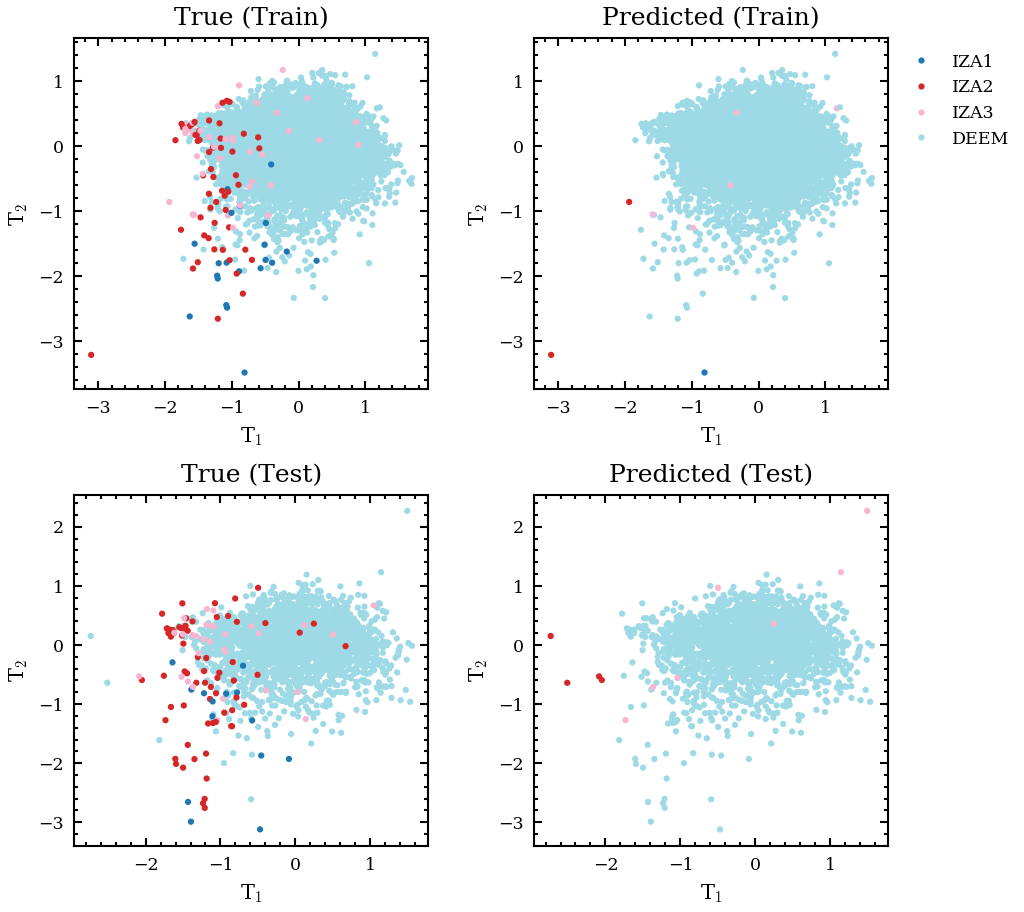

===== 3.5 | Gaussian | 4-Class =====


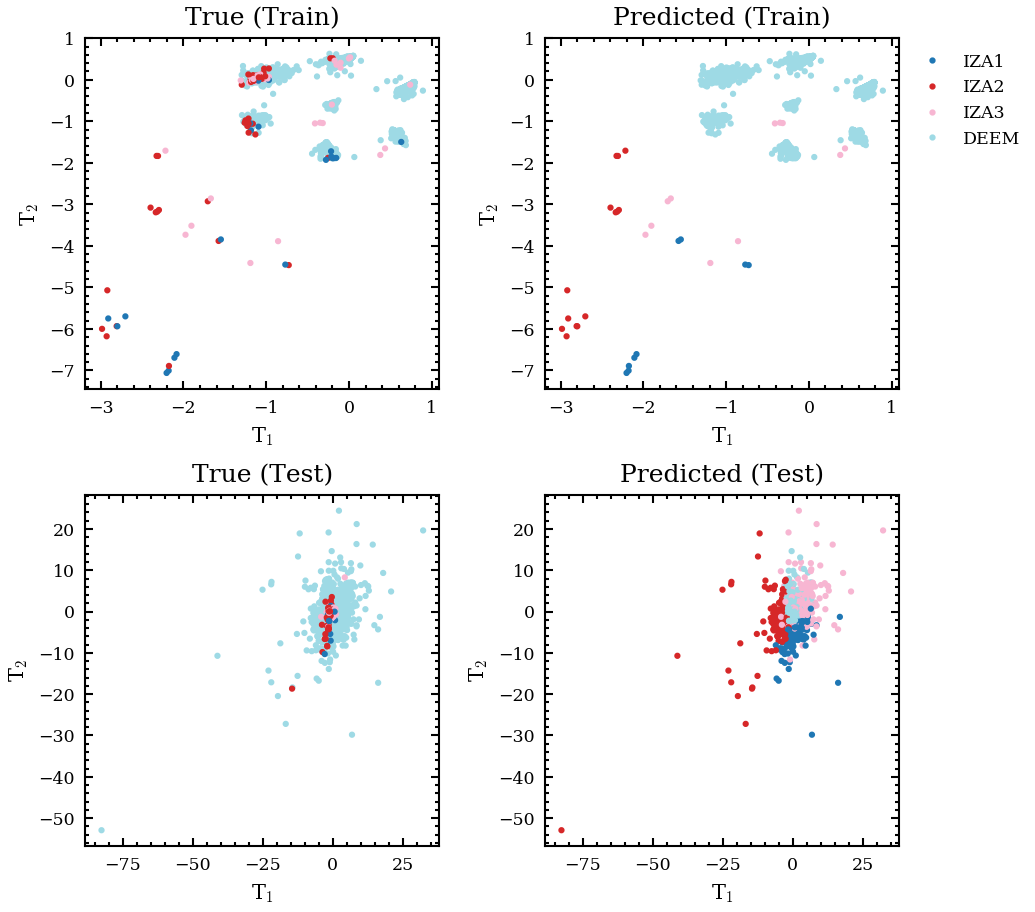

===== 6.0 | Linear | 4-Class =====


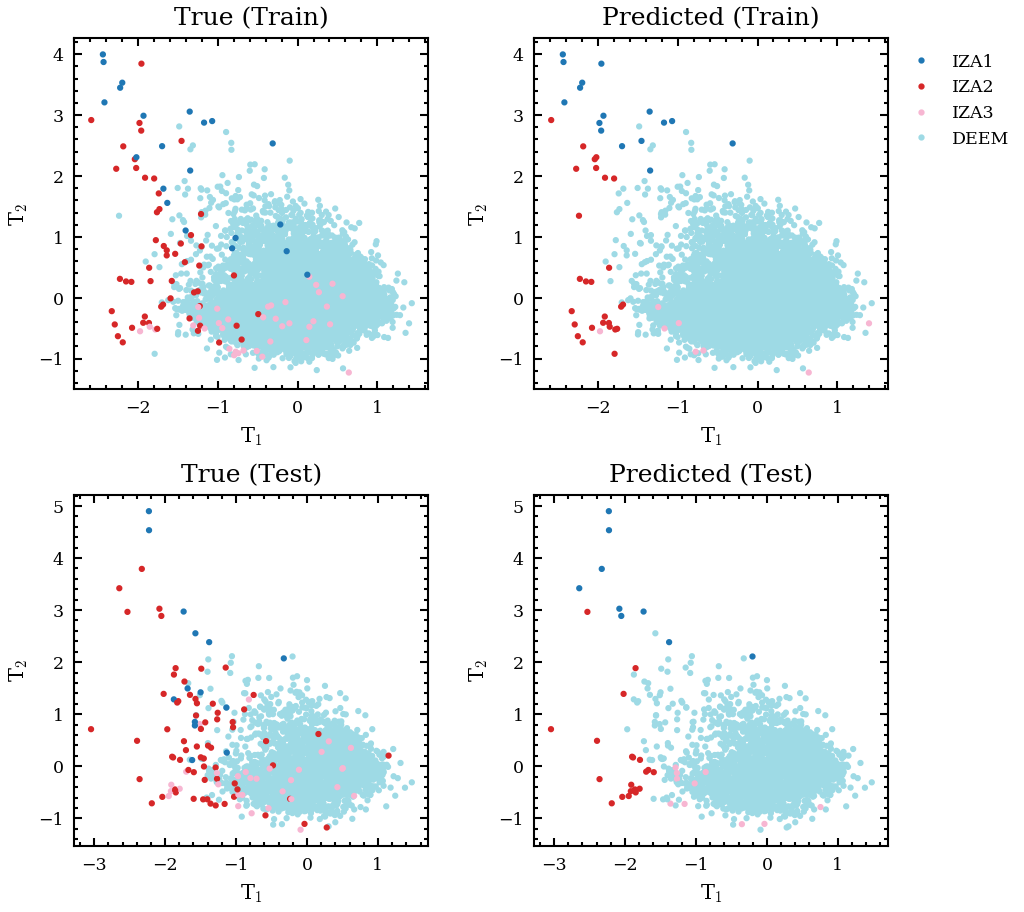

===== 6.0 | Gaussian | 4-Class =====


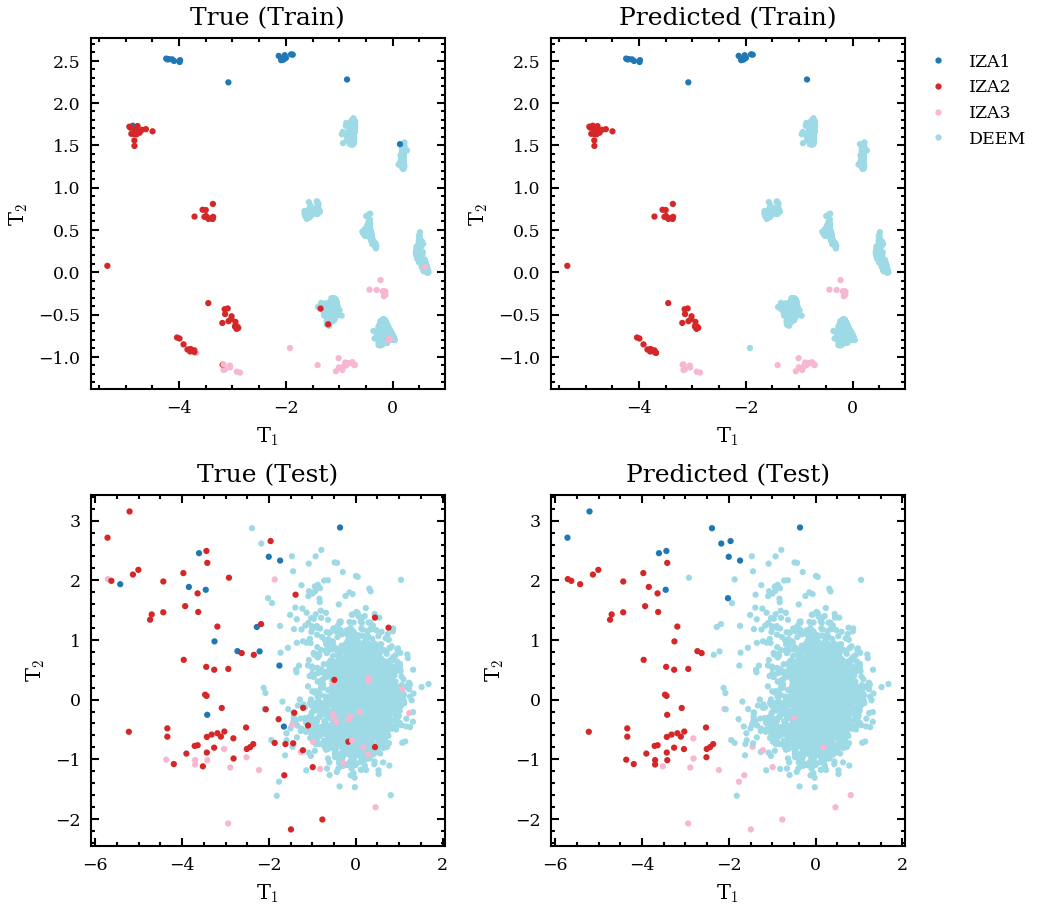

In [13]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in [4]: #(2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_name} | {n_cantons}-Class =====')
    
            # Load projections
            deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
            T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)

            iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
            T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

            # Load predicted cantons
            deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
            predicted_cantons_deem = np.loadtxt(deem_file, dtype=int)

            iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
            predicted_cantons_iza = np.loadtxt(iza_file, dtype=int)

            fig = plt.figure(figsize=(7.0, 7.0))
            axs_true_train = fig.add_subplot(2, 2, 1)
            axs_predicted_train = fig.add_subplot(2, 2, 2)
            axs_true_test = fig.add_subplot(2, 2, 3)
            axs_predicted_test = fig.add_subplot(2, 2, 4)
            scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)
            df_idx = 0

            axs_true_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                        c=cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
            axs_true_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                        c=cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

            axs_predicted_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                        #c=df_deem_train[:, df_idx])
                        c=predicted_cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
            axs_predicted_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                        #c=df_iza_train[:, df_idx])
                        c=predicted_cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

            axs_true_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                    c=cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
            axs_true_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                    c=cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

            axs_predicted_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                    #c=df_deem_test[:, df_idx])
                    c=predicted_cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
            axs_predicted_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                    #c=df_iza_test[:, df_idx])
                    c=predicted_cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

            handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
                       Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

            labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
            axs_predicted_train.legend(handles=handles, labels=labels, 
                                       loc='upper left', bbox_to_anchor=(1.0, 1.0))

            for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
                ax.set_xlabel(r'T$_1$')
                ax.set_ylabel(r'T$_2$')

            axs_true_train.set_title('True (Train)')
            axs_predicted_train.set_title('Predicted (Train)')
            axs_true_test.set_title('True (Test)')
            axs_predicted_test.set_title('Predicted (Test)')

            fig.subplots_adjust(wspace=0.3, hspace=0.3)

            #fig.savefig(f'../Results/{cutoff}/svm-kpcovr.png', bbox_inches='tight')

            plt.show()

## Classification statistics

### KernelSVC

In [19]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in (2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_name} | {n_cantons}-Class =====')
            
            predicted_cantons_iza = \
                np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
            predicted_cantons_deem = \
                np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

            predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                      predicted_cantons_deem[idxs_deem_train]))
            predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                     predicted_cantons_deem[idxs_deem_test]))

            matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
            matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)
            
            print('----- Train -----')
            print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                        zero_division=0))
            print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
            print()
            print(matrix_train)
            print()

            print('----- Test -----')
            print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                        zero_division=0))
            print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
            print()
            print(matrix_test)
            print()

===== 3.5 | Linear | 2-Class =====
----- Train -----
              precision    recall  f1-score   support

           1       0.96      0.22      0.36       112
           2       0.99      1.00      0.99      7750

    accuracy                           0.99      7862
   macro avg       0.98      0.61      0.68      7862
weighted avg       0.99      0.99      0.99      7862

Train accuracy: 0.9888069193589417

[[  25   87]
 [   1 7749]]

----- Test -----
              precision    recall  f1-score   support

           1       0.82      0.20      0.33       113
           2       0.96      1.00      0.98      2250

    accuracy                           0.96      2363
   macro avg       0.89      0.60      0.65      2363
weighted avg       0.95      0.96      0.95      2363

Test accuracy: 0.9597968683876428

[[  23   90]
 [   5 2245]]

===== 3.5 | Linear | 4-Class =====
----- Train -----
              precision    recall  f1-score   support

           1       0.62      0.38      0.

### KPCovR

In [20]:
for cutoff in cutoffs:
    for kernel_type in ('linear', 'gaussian'):
        kernel_name = kernel_type.capitalize()
        for n_cantons in (2, 4):
            data_dir = f'Kernel_Models/{kernel_name}/KSVC-KPCovR/{n_cantons}-Class'
            
            print(f'===== {cutoff} | {kernel_type} | {n_cantons}-Class =====')
            
            predicted_cantons_iza = \
                np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)
            predicted_cantons_deem = \
                np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)

            predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                      predicted_cantons_deem[idxs_deem_train]))
            predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                     predicted_cantons_deem[idxs_deem_test]))

            dfs_svc_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
            dfs_svc_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

            dfs_pcovr_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')
            dfs_pcovr_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')

            dfs_svc_train = np.concatenate((dfs_svc_iza[idxs_iza_train],
                                            dfs_svc_deem[idxs_deem_train]))
            dfs_svc_test = np.concatenate((dfs_svc_iza[idxs_iza_test],
                                           dfs_svc_deem[idxs_deem_test]))

            dfs_pcovr_train = np.concatenate((dfs_pcovr_iza[idxs_iza_train],
                                              dfs_pcovr_deem[idxs_deem_train]))
            dfs_pcovr_test = np.concatenate((dfs_pcovr_iza[idxs_iza_test],
                                             dfs_pcovr_deem[idxs_deem_test]))

            matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
            matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)
            
            print('----- Train -----')
            print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                        zero_division=0))
            print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
            print()
            print(matrix_train)
            print()
            print('Train DF MAE:', MAE(dfs_svc_train, dfs_pcovr_train))
            print()

            print('----- Test -----')
            print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                        zero_division=0))
            print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
            print()
            print(matrix_test)
            print()
            print('Test DF MAE:', MAE(dfs_svc_test, dfs_pcovr_test))
            print()

===== 3.5 | linear | 2-Class =====
----- Train -----
              precision    recall  f1-score   support

           1       0.96      0.22      0.36       112
           2       0.99      1.00      0.99      7750

    accuracy                           0.99      7862
   macro avg       0.98      0.61      0.68      7862
weighted avg       0.99      0.99      0.99      7862

Train accuracy: 0.9888069193589417

[[  25   87]
 [   1 7749]]

Train DF MAE: 2.741401678707708

----- Test -----
              precision    recall  f1-score   support

           1       0.82      0.20      0.33       113
           2       0.96      1.00      0.98      2250

    accuracy                           0.96      2363
   macro avg       0.89      0.60      0.65      2363
weighted avg       0.95      0.96      0.95      2363

Test accuracy: 0.9597968683876428

[[  23   90]
 [   5 2245]]

Test DF MAE: 2.7414060880236986

===== 3.5 | linear | 4-Class =====
----- Train -----
              precision    rec

# Linear Models

In [21]:
# Linear model setup
n_species = 2
group_names = {'power': ['OO', 'OSi', 'SiSi', 
                         'OO+OSi', 'OO+SiSi', 'OSi+SiSi',
                         'OO+OSi+SiSi'], 
               'radial': ['O', 'Si', 'O+Si']}

In [22]:
deem_name = 'DEEM_10k'
iza_name = 'IZA_226'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

## Plotting

===== 3.5 | 4-Class | Power | OO =====


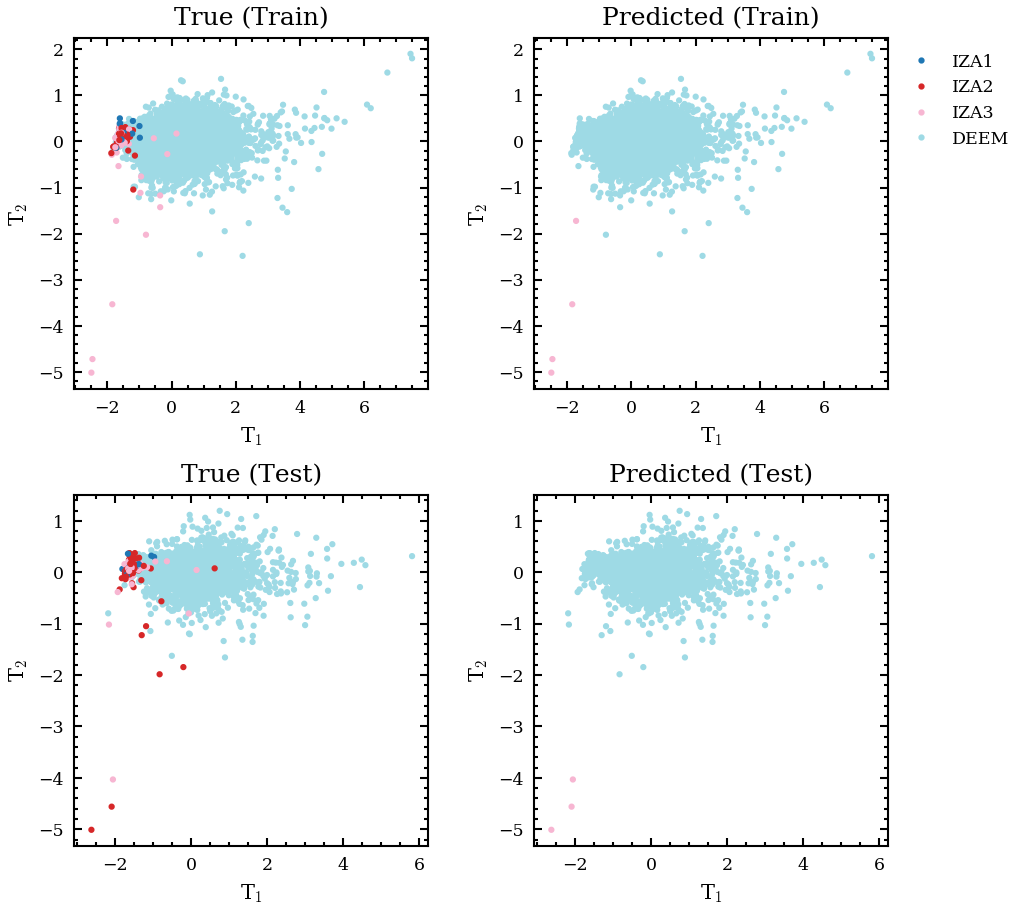

===== 3.5 | 4-Class | Power | OSi =====


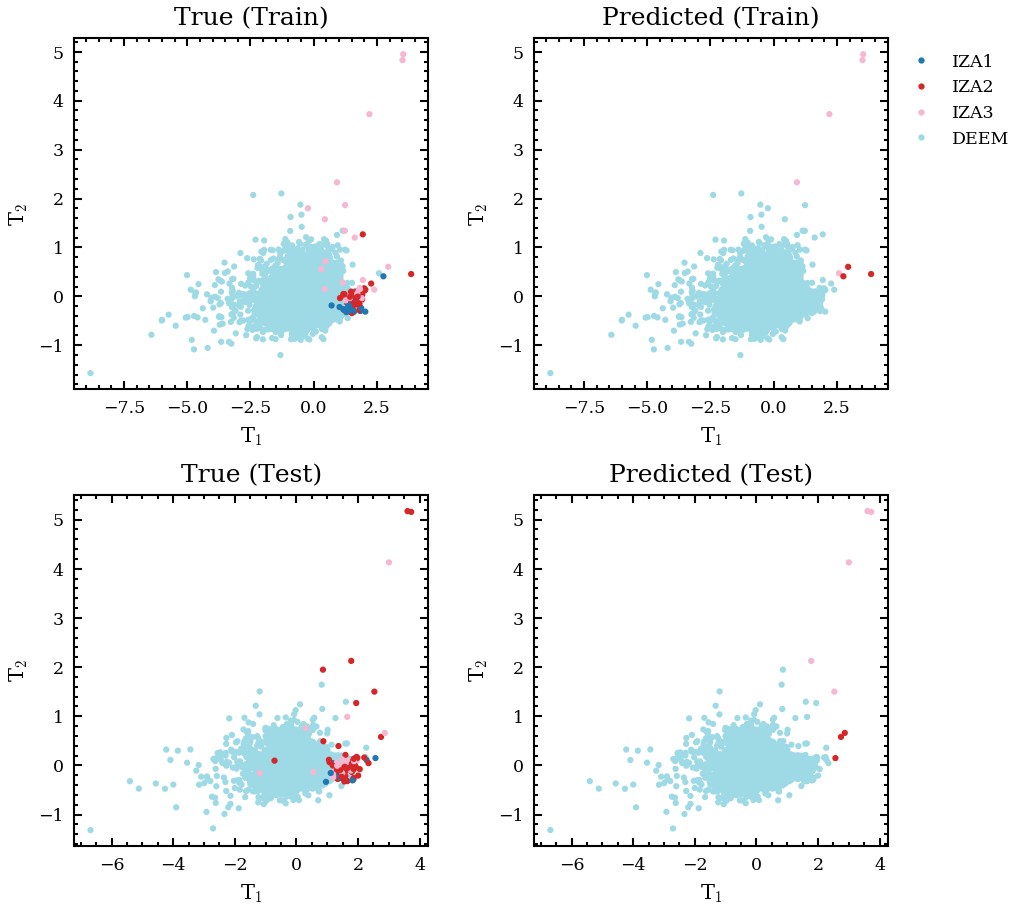

===== 3.5 | 4-Class | Power | SiSi =====


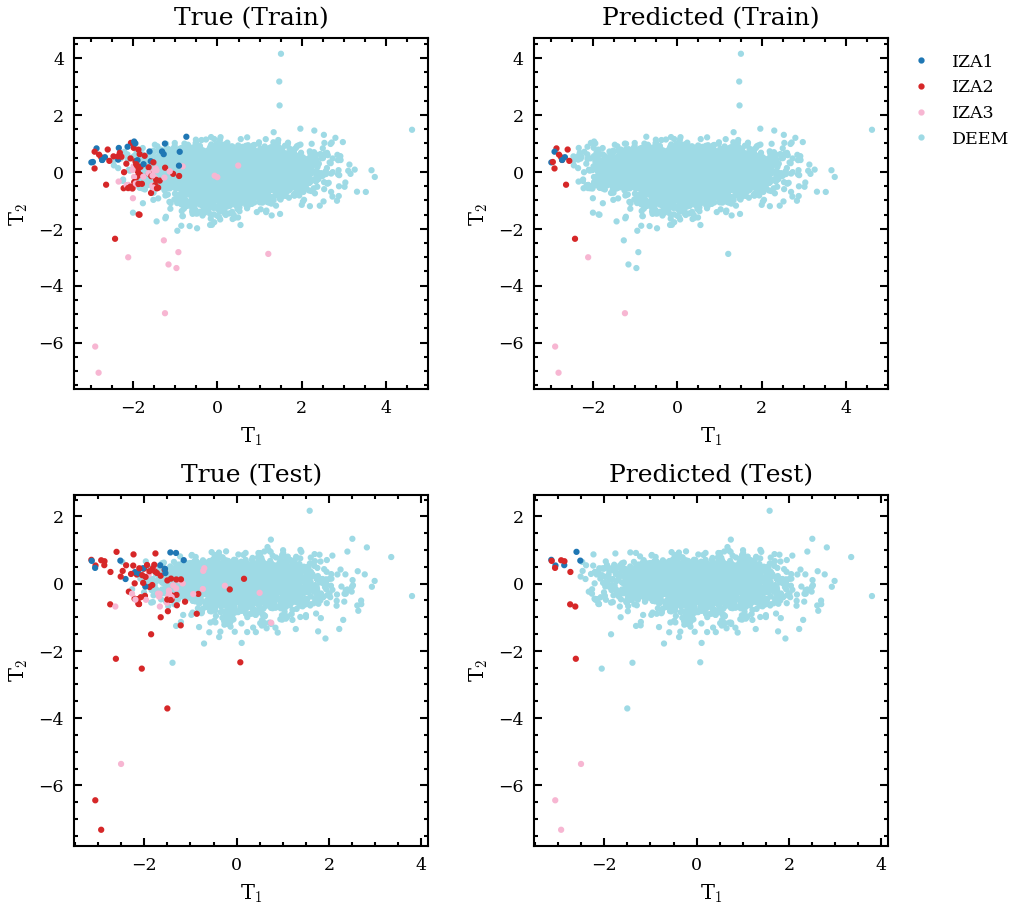

===== 3.5 | 4-Class | Power | OO+OSi =====


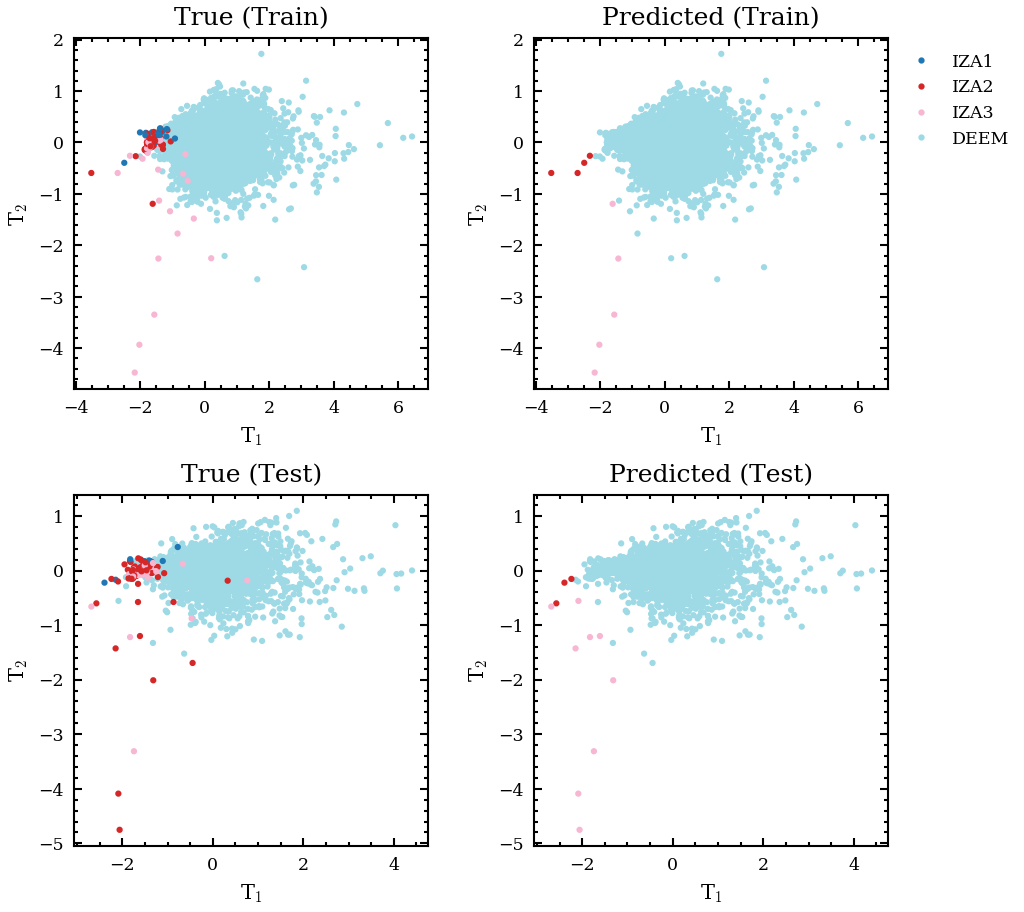

===== 3.5 | 4-Class | Power | OO+SiSi =====


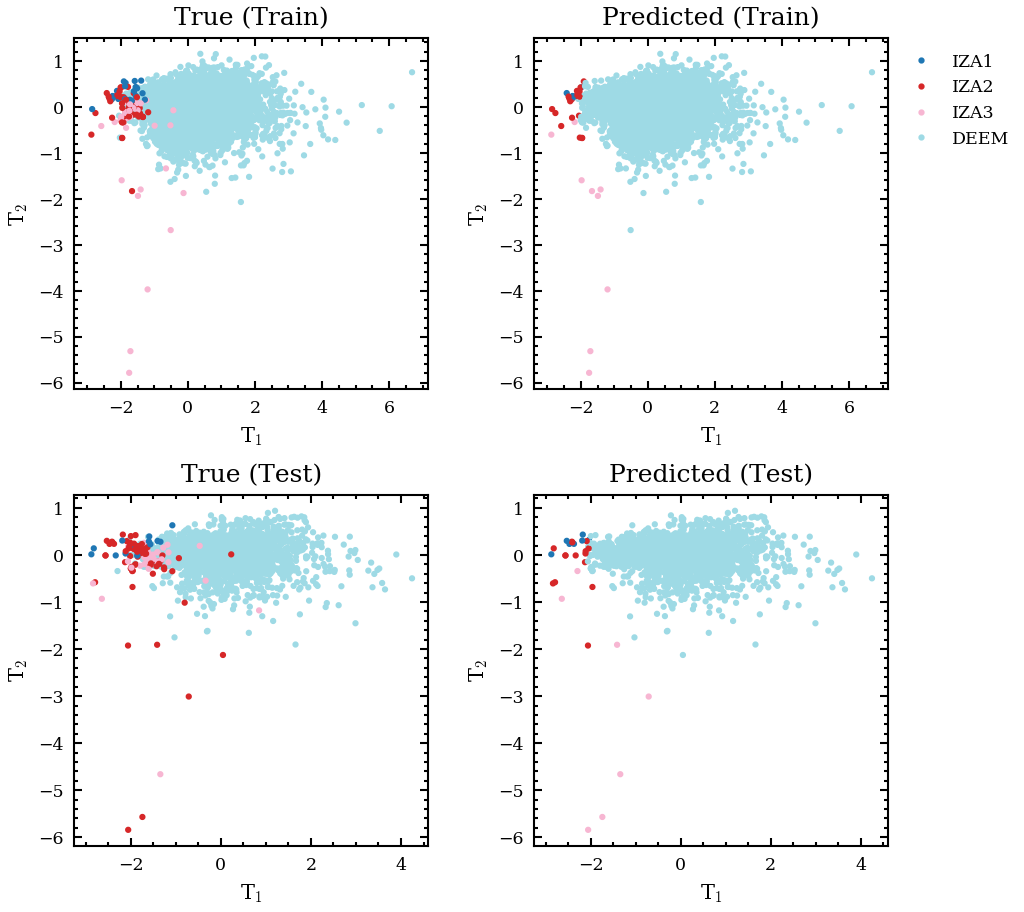

===== 3.5 | 4-Class | Power | OSi+SiSi =====


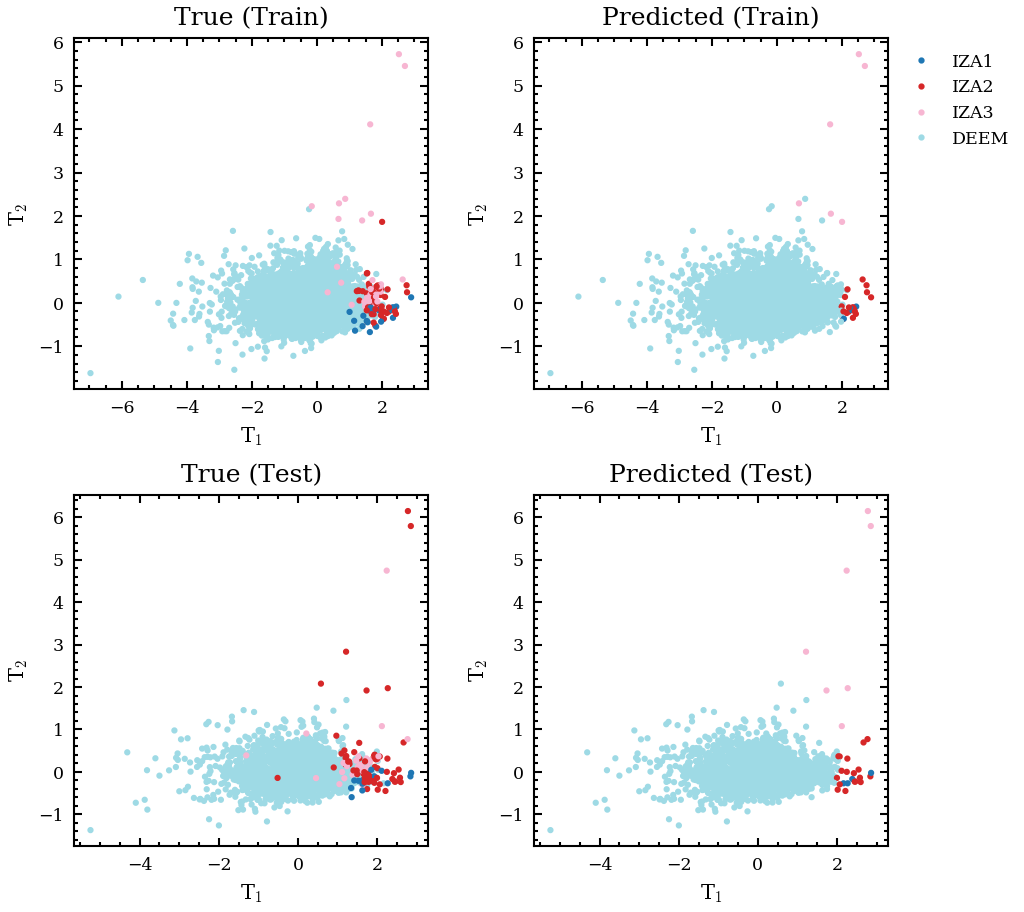

===== 3.5 | 4-Class | Power | OO+OSi+SiSi =====


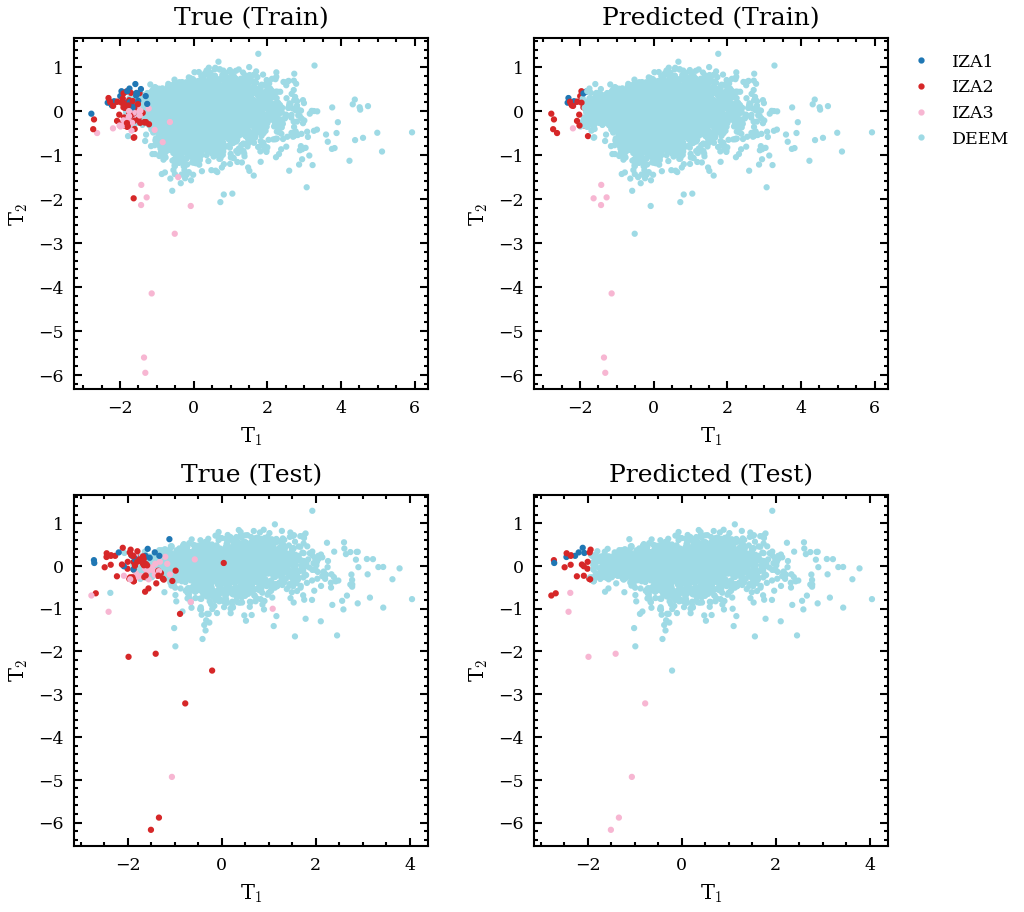

===== 3.5 | 4-Class | Radial | O =====


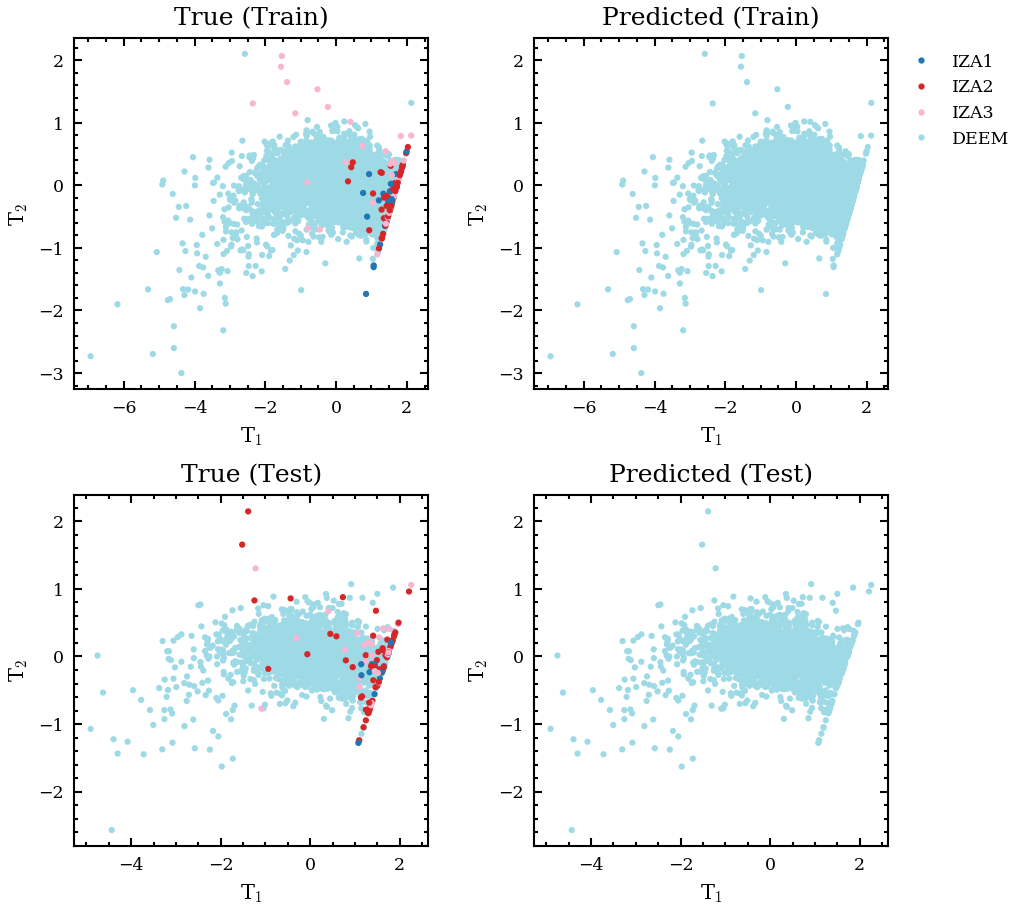

===== 3.5 | 4-Class | Radial | Si =====


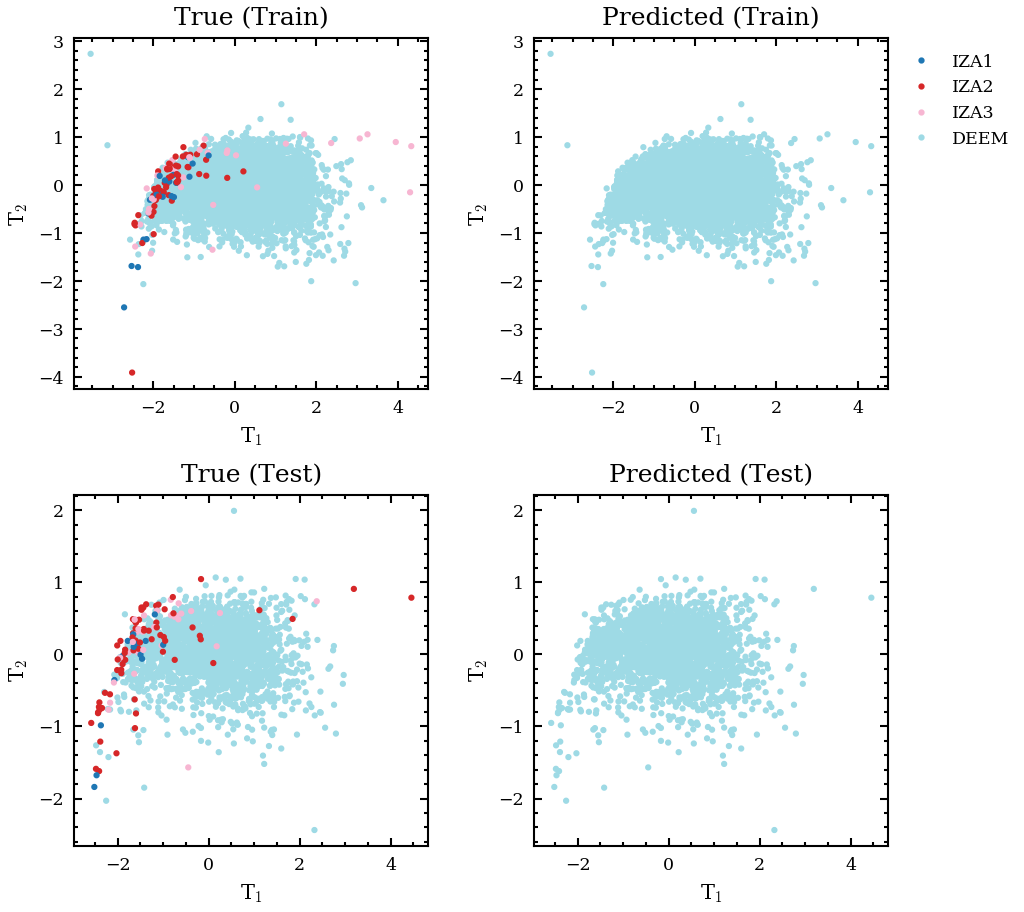

===== 3.5 | 4-Class | Radial | O+Si =====


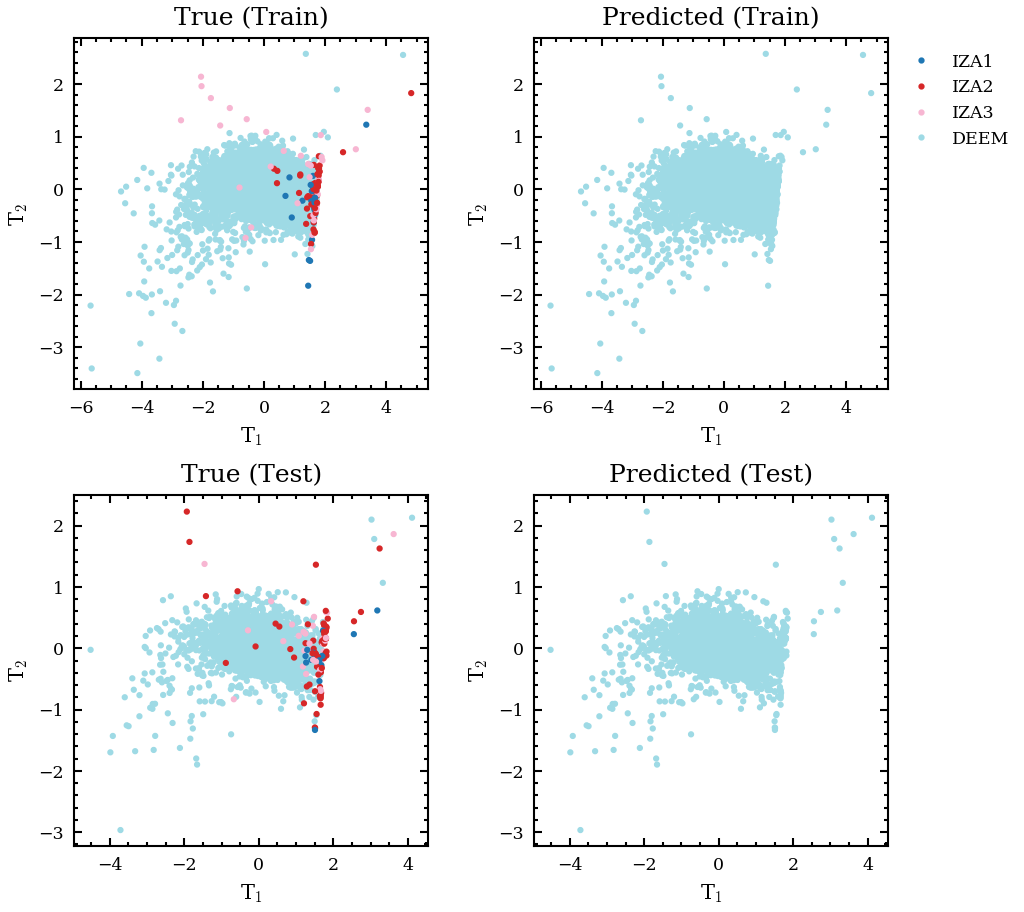

===== 6.0 | 4-Class | Power | OO =====


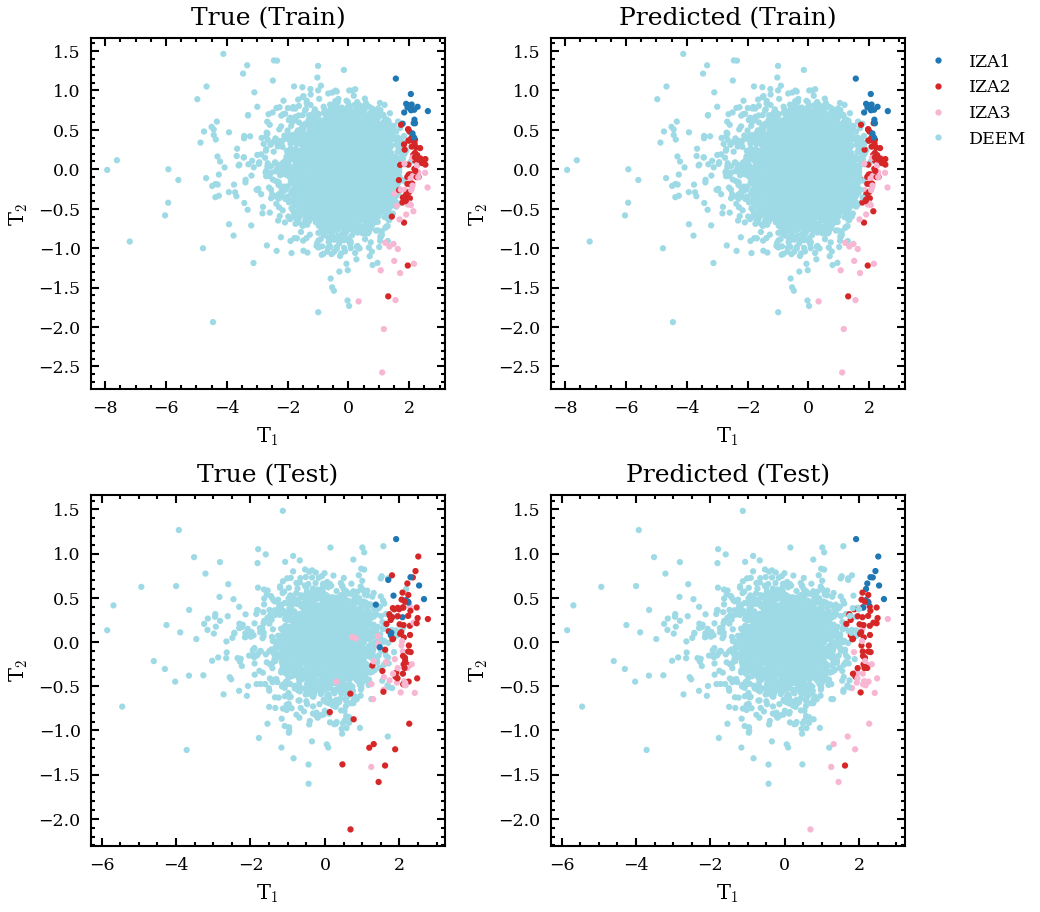

===== 6.0 | 4-Class | Power | OSi =====


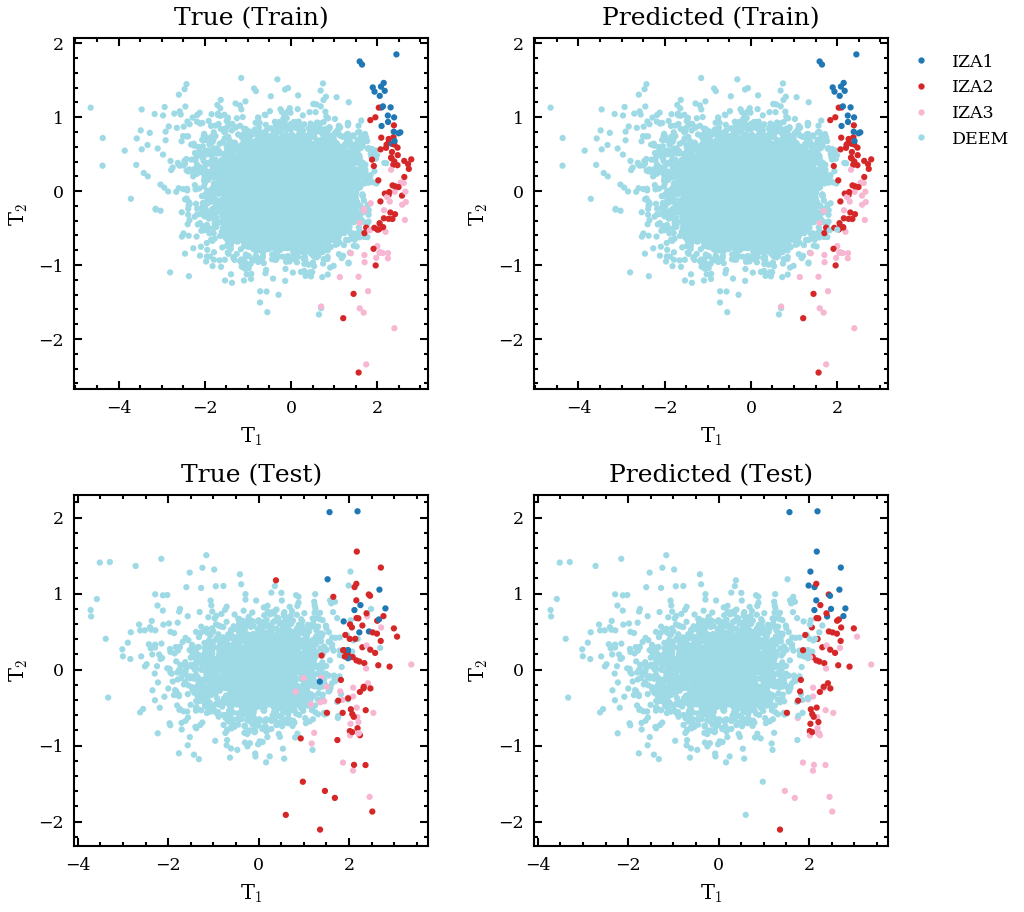

===== 6.0 | 4-Class | Power | SiSi =====


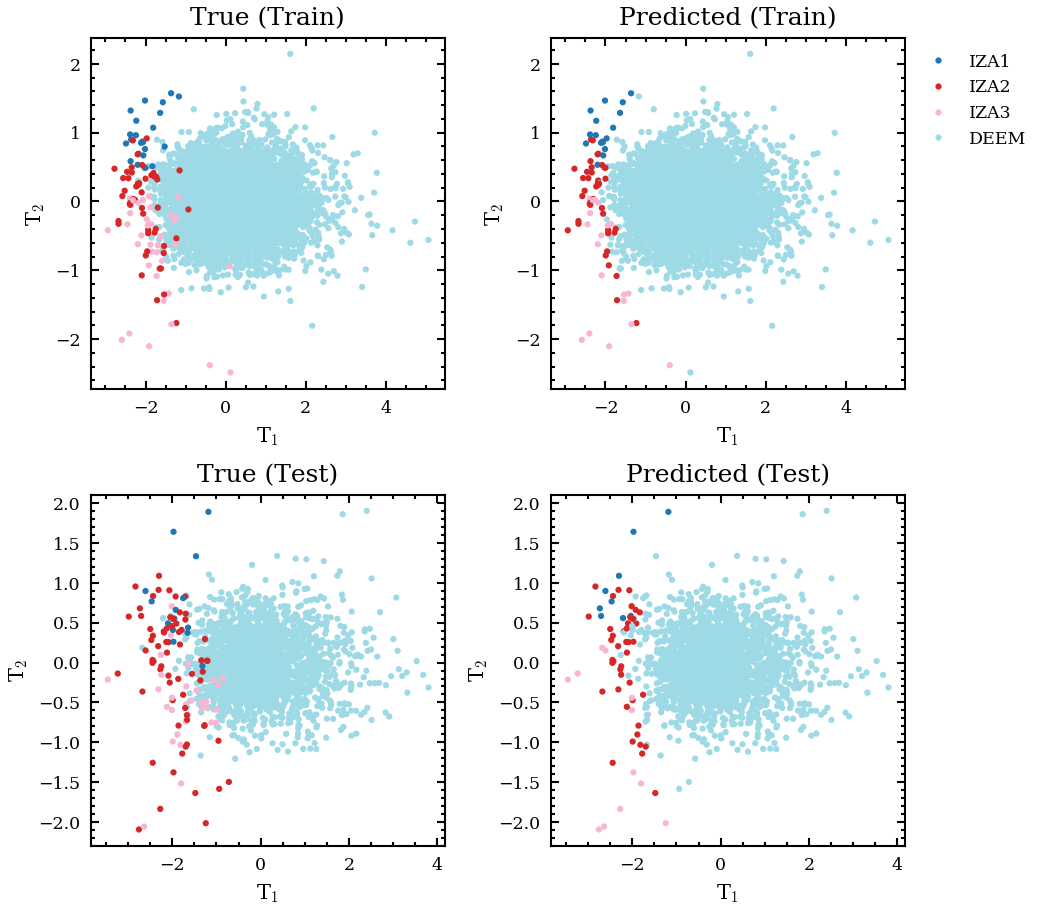

===== 6.0 | 4-Class | Power | OO+OSi =====


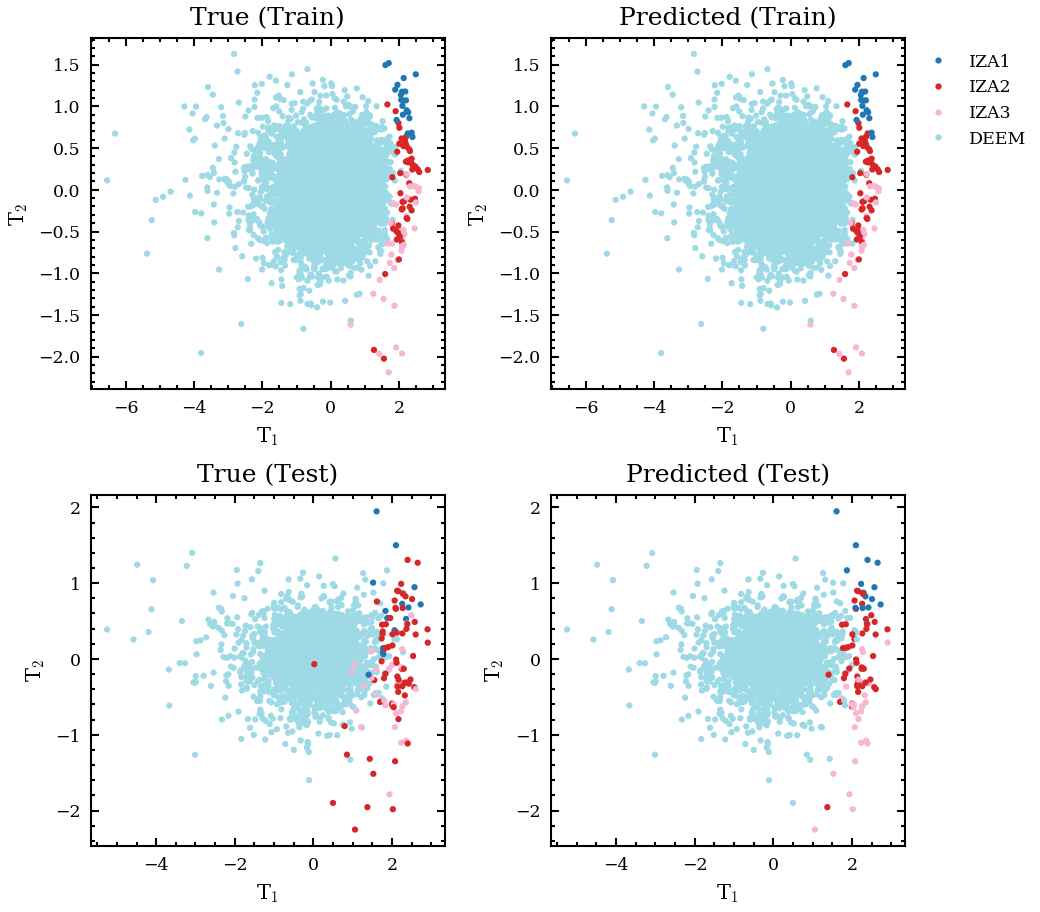

===== 6.0 | 4-Class | Power | OO+SiSi =====


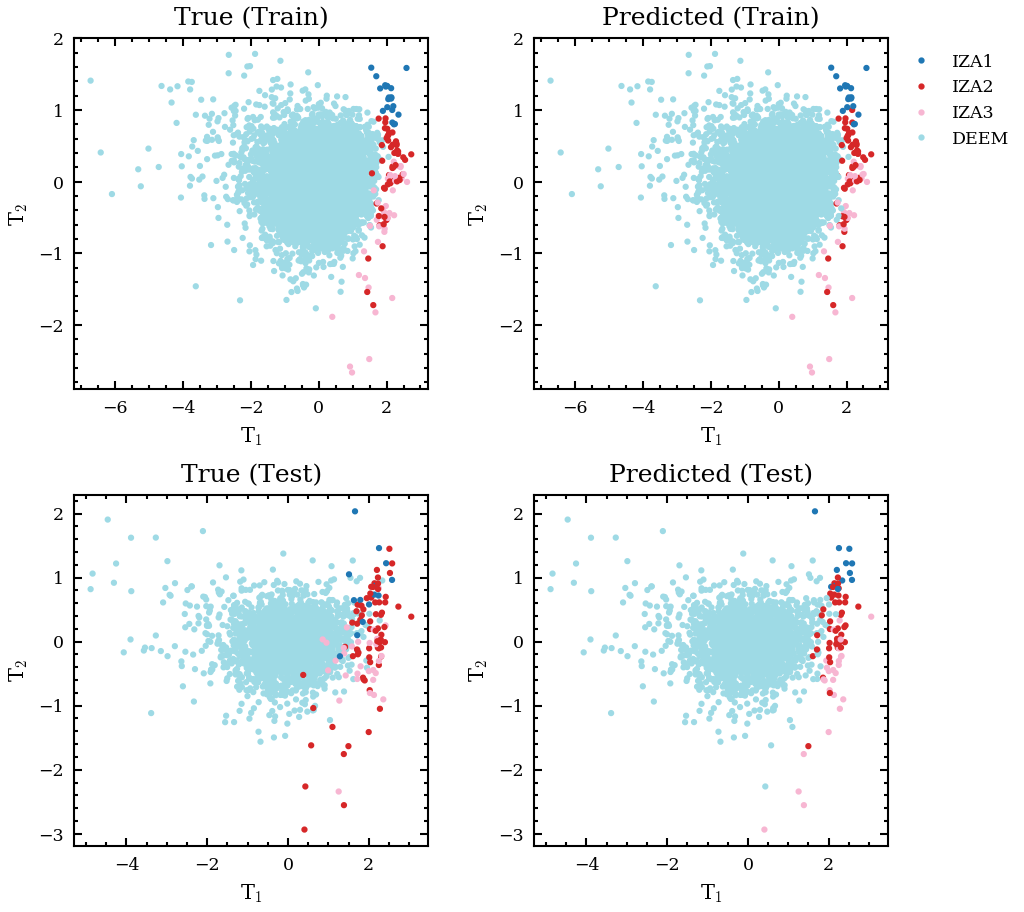

===== 6.0 | 4-Class | Power | OSi+SiSi =====


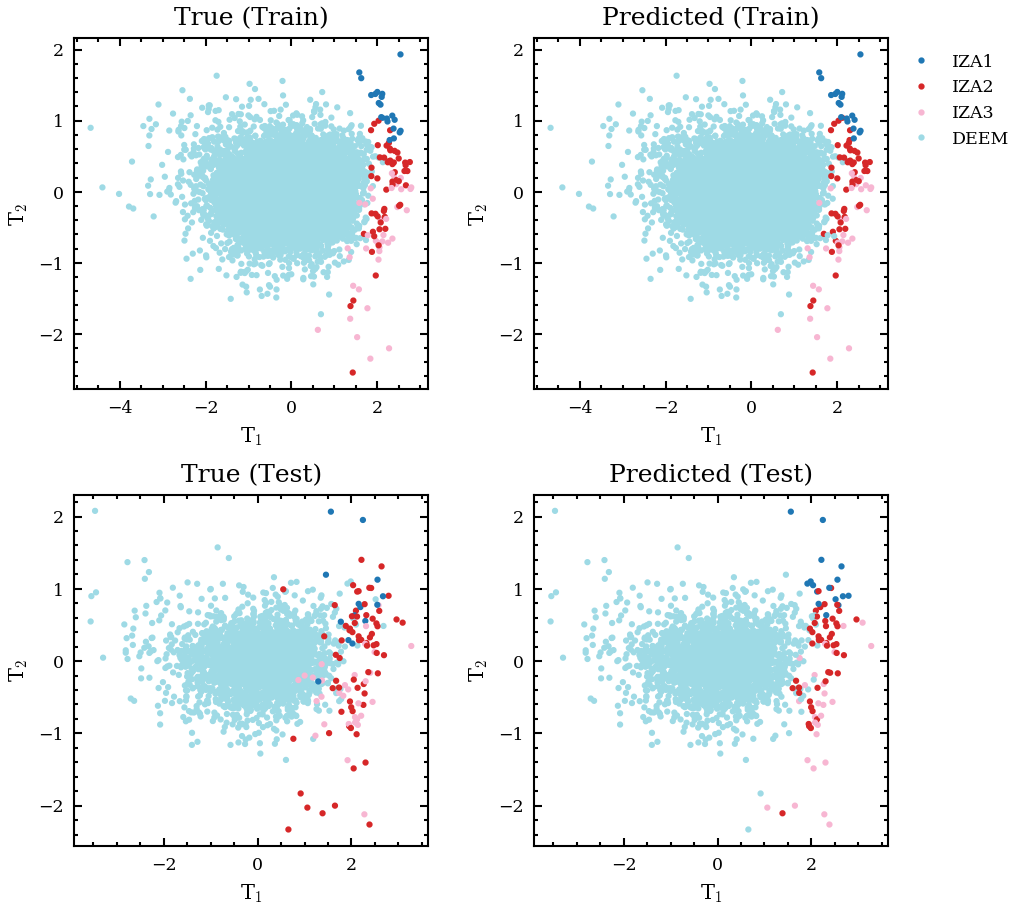

===== 6.0 | 4-Class | Power | OO+OSi+SiSi =====


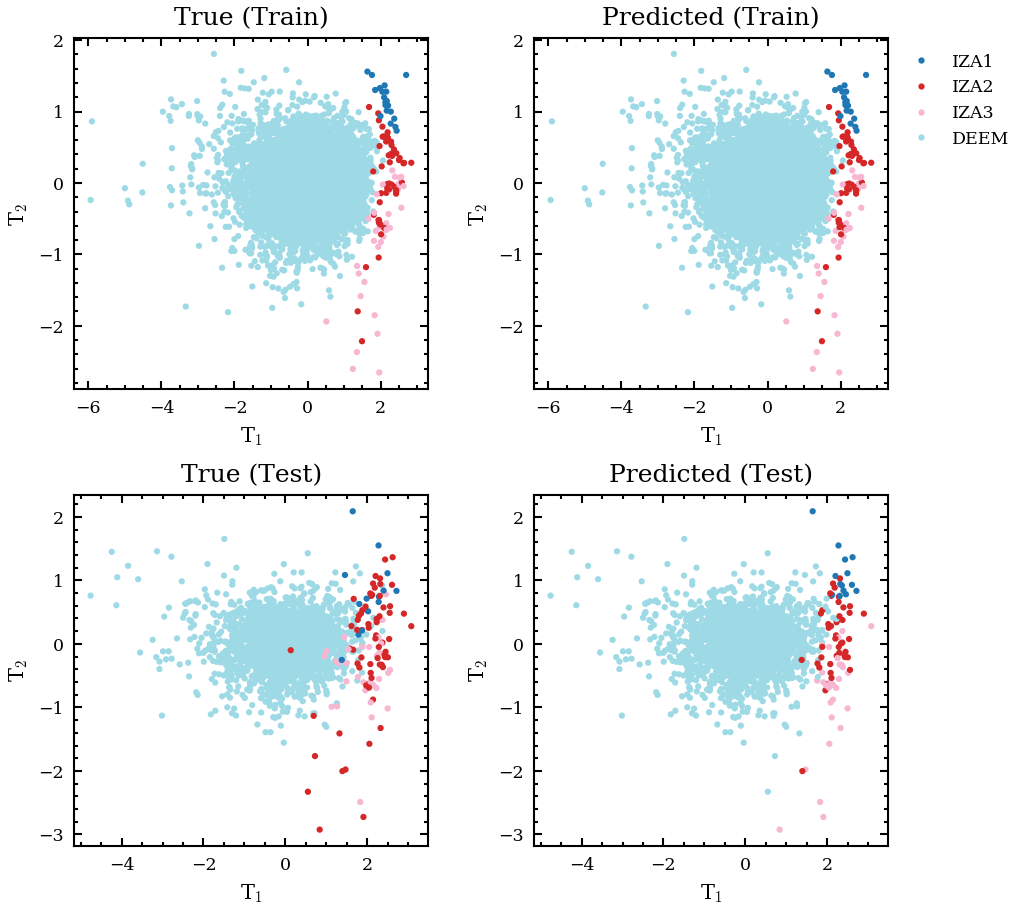

===== 6.0 | 4-Class | Radial | O =====


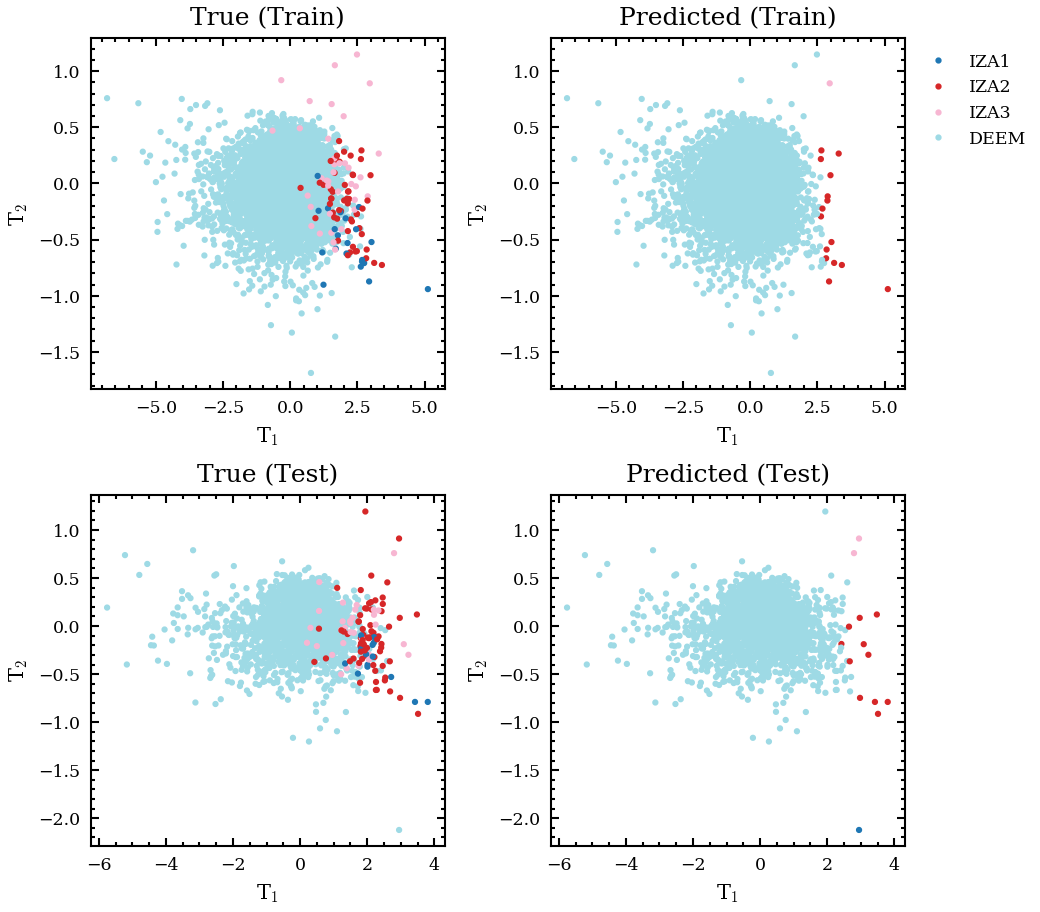

===== 6.0 | 4-Class | Radial | Si =====


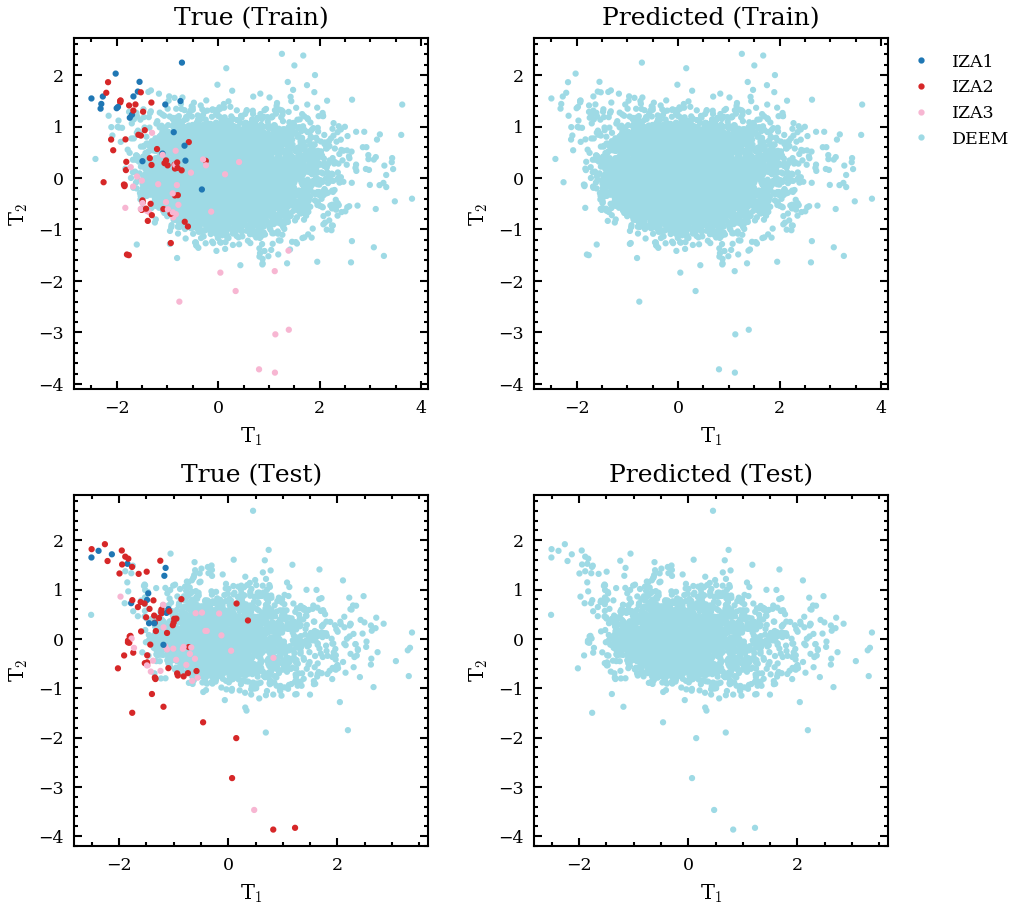

===== 6.0 | 4-Class | Radial | O+Si =====


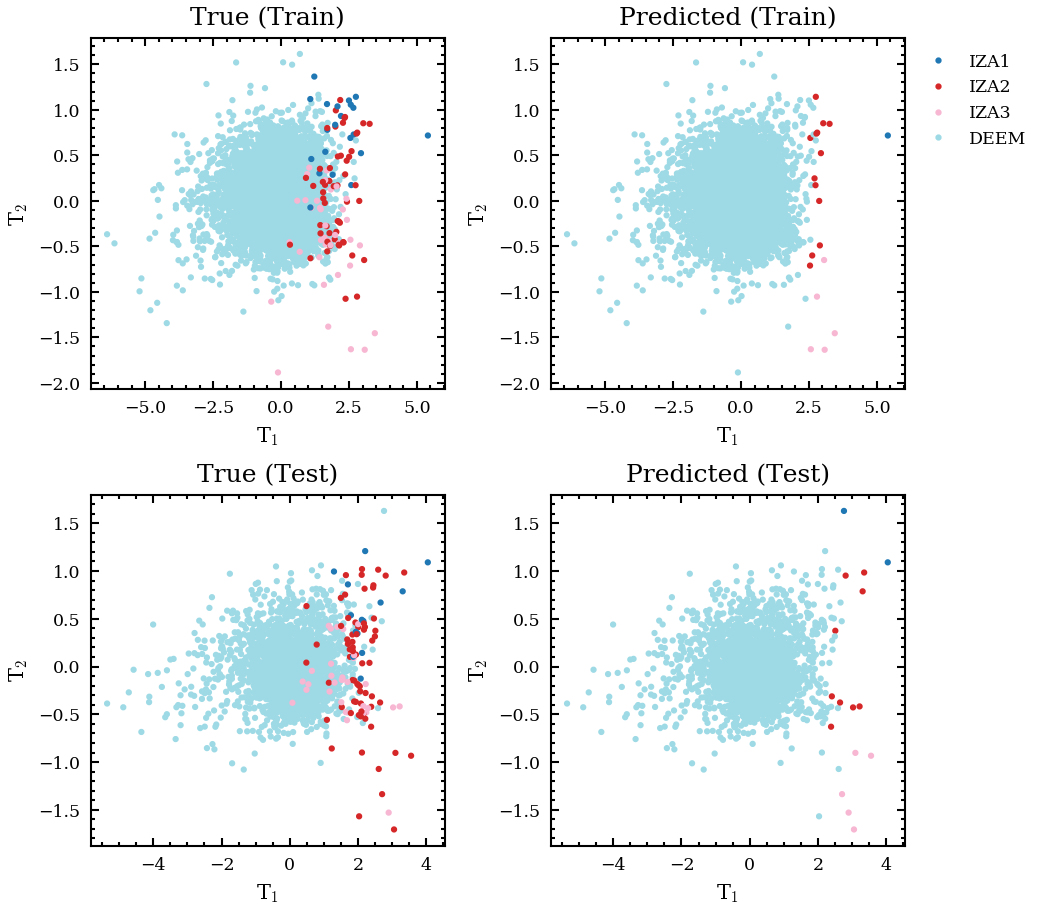

In [24]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in [4]: #(2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')
    
                # Load projections
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
                T_deem = utils.load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)

                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structures.hdf5'
                T_iza = utils.load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

                # Load predicted cantons
                deem_file = f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
                predicted_cantons_deem = np.loadtxt(deem_file, dtype=int)

                iza_file = f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat'
                predicted_cantons_iza = np.loadtxt(iza_file, dtype=int)

                fig = plt.figure(figsize=(7.0, 7.0))
                axs_true_train = fig.add_subplot(2, 2, 1)
                axs_predicted_train = fig.add_subplot(2, 2, 2)
                axs_true_test = fig.add_subplot(2, 2, 3)
                axs_predicted_test = fig.add_subplot(2, 2, 4)
                scatter_opts = dict(cmap='tab20', vmin=1, vmax=4)
                df_idx = 0

                axs_true_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                            c=cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
                axs_true_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                            c=cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

                axs_predicted_train.scatter(T_deem[idxs_deem_train, 0], T_deem[idxs_deem_train, 1], 
                            #c=df_deem_train[:, df_idx])
                            c=predicted_cantons_deem[idxs_deem_train], zorder=2, **scatter_opts)
                axs_predicted_train.scatter(T_iza[idxs_iza_train, 0], T_iza[idxs_iza_train, 1], 
                            #c=df_iza_train[:, df_idx])
                            c=predicted_cantons_iza[idxs_iza_train], zorder=3, **scatter_opts)

                axs_true_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                        c=cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
                axs_true_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                        c=cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

                axs_predicted_test.scatter(T_deem[idxs_deem_test, 0], T_deem[idxs_deem_test, 1],
                        #c=df_deem_test[:, df_idx])
                        c=predicted_cantons_deem[idxs_deem_test], zorder=2, **scatter_opts)
                axs_predicted_test.scatter(T_iza[idxs_iza_test, 0], T_iza[idxs_iza_test, 1],
                        #c=df_iza_test[:, df_idx])
                        c=predicted_cantons_iza[idxs_iza_test], zorder=3, **scatter_opts)

                handles = [Line2D([0], [0], c=plt.get_cmap('tab20')(0.0), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(0.33), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(0.67), marker='o', linewidth=0),
                           Line2D([0], [0], c=plt.get_cmap('tab20')(1.0), marker='o', linewidth=0)]

                labels = ['IZA1', 'IZA2', 'IZA3', 'DEEM']
                axs_predicted_train.legend(handles=handles, labels=labels, 
                                           loc='upper left', bbox_to_anchor=(1.0, 1.0))

                for ax in (axs_true_train, axs_predicted_train, axs_true_test, axs_predicted_test):
                    ax.set_xlabel(r'T$_1$')
                    ax.set_ylabel(r'T$_2$')

                axs_true_train.set_title('True (Train)')
                axs_predicted_train.set_title('Predicted (Train)')
                axs_true_test.set_title('True (Test)')
                axs_predicted_test.set_title('Predicted (Test)')

                fig.subplots_adjust(wspace=0.3, hspace=0.3)

                #fig.savefig(f'../Results/{cutoff}/svm-kpcovr.png', bbox_inches='tight')

                plt.show()

## Classification statistics

### LinearSVC

In [25]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')

                predicted_cantons_iza = \
                    np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)
                predicted_cantons_deem = \
                    np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int)

                predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                          predicted_cantons_deem[idxs_deem_train]))
                predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                         predicted_cantons_deem[idxs_deem_test]))

                matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
                matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

                print('----- Train -----')
                print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                            zero_division=0))
                print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
                print()
                print(matrix_train)
                print()

                print('----- Test -----')
                print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                            zero_division=0))
                print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
                print()
                print(matrix_test)
                print()

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       1.00      0.04      0.07       112
           2       0.99      1.00      0.99      7750

    accuracy                           0.99      7862
   macro avg       0.99      0.52      0.53      7862
weighted avg       0.99      0.99      0.98      7862

Train accuracy: 0.9862630373950648

[[   4  108]
 [   0 7750]]

----- Test -----
              precision    recall  f1-score   support

           1       0.80      0.04      0.07       113
           2       0.95      1.00      0.98      2250

    accuracy                           0.95      2363
   macro avg       0.88      0.52      0.52      2363
weighted avg       0.95      0.95      0.93      2363

Test accuracy: 0.9534490055014812

[[   4  109]
 [   1 2249]]

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.00      0.00

----- Train -----
              precision    recall  f1-score   support

           1       0.91      0.36      0.51       112
           2       0.99      1.00      1.00      7750

    accuracy                           0.99      7862
   macro avg       0.95      0.68      0.75      7862
weighted avg       0.99      0.99      0.99      7862

Train accuracy: 0.9903332485372679

[[  40   72]
 [   4 7746]]

----- Test -----
              precision    recall  f1-score   support

           1       0.88      0.39      0.54       113
           2       0.97      1.00      0.98      2250

    accuracy                           0.97      2363
   macro avg       0.93      0.69      0.76      2363
weighted avg       0.97      0.97      0.96      2363

Test accuracy: 0.9682606855691918

[[  44   69]
 [   6 2244]]

===== 3.5 | 4-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.60      0.14      0.23        21
           2 

----- Train -----
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       112
           2       0.99      1.00      0.99      7750

    accuracy                           0.99      7862
   macro avg       0.49      0.50      0.50      7862
weighted avg       0.97      0.99      0.98      7862

Train accuracy: 0.9857542610022895

[[   0  112]
 [   0 7750]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       113
           2       0.95      1.00      0.98      2250

    accuracy                           0.95      2363
   macro avg       0.48      0.50      0.49      2363
weighted avg       0.91      0.95      0.93      2363

Test accuracy: 0.9521794329242488

[[   0  113]
 [   0 2250]]

===== 3.5 | 4-Class | Radial | Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2     

----- Train -----
              precision    recall  f1-score   support

           1       0.92      0.72      0.81       112
           2       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       0.96      0.86      0.90      7862
weighted avg       0.99      1.00      0.99      7862

Train accuracy: 0.9951666242686339

[[  81   31]
 [   7 7743]]

----- Test -----
              precision    recall  f1-score   support

           1       0.94      0.58      0.72       113
           2       0.98      1.00      0.99      2250

    accuracy                           0.98      2363
   macro avg       0.96      0.79      0.86      2363
weighted avg       0.98      0.98      0.98      2363

Test accuracy: 0.9784172661870504

[[  66   47]
 [   4 2246]]

===== 6.0 | 4-Class | Power | SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.94      0.71      0.81        21
           2    

----- Train -----
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       112
           2       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       1.00      1.00      1.00      7862
weighted avg       1.00      1.00      1.00      7862

Train accuracy: 1.0

[[ 112    0]
 [   0 7750]]

----- Test -----
              precision    recall  f1-score   support

           1       0.91      0.74      0.82       113
           2       0.99      1.00      0.99      2250

    accuracy                           0.98      2363
   macro avg       0.95      0.87      0.91      2363
weighted avg       0.98      0.98      0.98      2363

Test accuracy: 0.9843419382141346

[[  84   29]
 [   8 2242]]

===== 6.0 | 4-Class | Power | OO+OSi+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       0.98 

### PCovR

In [28]:
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'Linear_Models/LSVC-LPCovR/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | Linear | {n_cantons}-Class =====')
            
                predicted_cantons_iza = \
                    np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)
                predicted_cantons_deem = \
                    np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_cantons.dat', dtype=int)

                predicted_cantons_train = np.concatenate((predicted_cantons_iza[idxs_iza_train],
                                                          predicted_cantons_deem[idxs_deem_train]))
                predicted_cantons_test = np.concatenate((predicted_cantons_iza[idxs_iza_test],
                                                         predicted_cantons_deem[idxs_deem_test]))

                dfs_svc_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
                dfs_svc_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

                dfs_pcovr_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')
                dfs_pcovr_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/pcovr_structure_dfs.dat')

                dfs_svc_train = np.concatenate((dfs_svc_iza[idxs_iza_train],
                                                dfs_svc_deem[idxs_deem_train]))
                dfs_svc_test = np.concatenate((dfs_svc_iza[idxs_iza_test],
                                               dfs_svc_deem[idxs_deem_test]))

                dfs_pcovr_train = np.concatenate((dfs_pcovr_iza[idxs_iza_train],
                                                  dfs_pcovr_deem[idxs_deem_train]))
                dfs_pcovr_test = np.concatenate((dfs_pcovr_iza[idxs_iza_test],
                                                 dfs_pcovr_deem[idxs_deem_test]))

                matrix_train = confusion_matrix(cantons_train[n_cantons], predicted_cantons_train)
                matrix_test = confusion_matrix(cantons_test[n_cantons], predicted_cantons_test)

                print('----- Train -----')
                print(classification_report(cantons_train[n_cantons], predicted_cantons_train,
                                            zero_division=0))
                print('Train accuracy:', np.sum(np.diag(matrix_train)) / np.sum(matrix_train))
                print()
                print(matrix_train)
                print()
                print('Train DF MAE:', MAE(dfs_svc_train, dfs_pcovr_train))
                print()

                print('----- Test -----')
                print(classification_report(cantons_test[n_cantons], predicted_cantons_test,
                                            zero_division=0))
                print('Test accuracy:', np.sum(np.diag(matrix_test)) / np.sum(matrix_test))
                print()
                print(matrix_test)
                print()
                print('Test DF MAE:', MAE(dfs_svc_test, dfs_pcovr_test))
                print()

===== 3.5 | Linear | 2-Class =====
----- Train -----
              precision    recall  f1-score   support

           1       1.00      0.04      0.07       112
           2       0.99      1.00      0.99      7750

    accuracy                           0.99      7862
   macro avg       0.99      0.52      0.53      7862
weighted avg       0.99      0.99      0.98      7862

Train accuracy: 0.9862630373950648

[[   4  108]
 [   0 7750]]

Train DF MAE: 1.6002266196896464

----- Test -----
              precision    recall  f1-score   support

           1       0.80      0.04      0.07       113
           2       0.95      1.00      0.98      2250

    accuracy                           0.95      2363
   macro avg       0.88      0.52      0.52      2363
weighted avg       0.95      0.95      0.93      2363

Test accuracy: 0.9534490055014812

[[   4  109]
 [   1 2249]]

Test DF MAE: 1.6184828192975032

===== 3.5 | Linear | 4-Class =====
----- Train -----
              precision    re

----- Train -----
              precision    recall  f1-score   support

           1       0.60      0.14      0.23        21
           2       0.63      0.22      0.33        54
           3       0.78      0.19      0.30        37
           4       0.99      1.00      0.99      7750

    accuracy                           0.99      7862
   macro avg       0.75      0.39      0.46      7862
weighted avg       0.99      0.99      0.98      7862

Train accuracy: 0.9882981429661664

[[   3    4    0   14]
 [   2   12    2   38]
 [   0    1    7   29]
 [   0    2    0 7748]]

Train DF MAE: [2.90702897 2.57507506 1.5809061  2.34283535]

----- Test -----
              precision    recall  f1-score   support

           1       0.29      0.14      0.19        14
           2       0.73      0.16      0.27        68
           3       0.29      0.06      0.11        31
           4       0.96      1.00      0.98      2250

    accuracy                           0.96      2363
   macro avg 

----- Train -----
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        37
           4       0.99      1.00      0.99      7750

    accuracy                           0.99      7862
   macro avg       0.25      0.25      0.25      7862
weighted avg       0.97      0.99      0.98      7862

Train accuracy: 0.9857542610022895

[[   0    0    0   21]
 [   0    0    0   54]
 [   0    0    0   37]
 [   0    0    0 7750]]

Train DF MAE: [1.06329363 1.04414563 1.01469562 0.99771247]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        68
           3       0.00      0.00      0.00        31
           4       0.95      1.00      0.98      2250

    accuracy                           0.95      2363
   macro avg 

----- Train -----
              precision    recall  f1-score   support

           1       0.94      0.71      0.81        21
           2       0.83      0.65      0.73        54
           3       0.84      0.43      0.57        37
           4       1.00      1.00      1.00      7750

    accuracy                           0.99      7862
   macro avg       0.90      0.70      0.78      7862
weighted avg       0.99      0.99      0.99      7862

Train accuracy: 0.9940218773848893

[[  15    3    0    3]
 [   1   35    3   15]
 [   0    3   16   18]
 [   0    1    0 7749]]

Train DF MAE: [3.06373673 2.97802971 2.43386786 2.59979225]

----- Test -----
              precision    recall  f1-score   support

           1       0.44      0.29      0.35        14
           2       0.76      0.47      0.58        68
           3       0.46      0.19      0.27        31
           4       0.98      1.00      0.99      2250

    accuracy                           0.97      2363
   macro avg 

----- Train -----
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           2       0.98      1.00      0.99        54
           3       1.00      0.97      0.99        37
           4       1.00      1.00      1.00      7750

    accuracy                           1.00      7862
   macro avg       1.00      0.99      0.99      7862
weighted avg       1.00      1.00      1.00      7862

Train accuracy: 0.9998728059018062

[[  21    0    0    0]
 [   0   54    0    0]
 [   0    1   36    0]
 [   0    0    0 7750]]

Train DF MAE: [5.04895847 5.93150173 4.57759052 5.36000728]

----- Test -----
              precision    recall  f1-score   support

           1       0.36      0.36      0.36        14
           2       0.75      0.49      0.59        68
           3       0.41      0.39      0.40        31
           4       0.99      1.00      0.99      2250

    accuracy                           0.97      2363
   macro avg 